In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
#Modelling
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.model_selection import RandomizedSearchCV
from catboost import CatBoostClassifier
from xgboost import XGBClassifier

In [2]:
df = pd.read_csv('Data/loan_train.csv')

In [3]:
df.head(5)

,Gender,Married,Dependents,Education,Self_Employed,Applicant_Income,Coapplicant_Income,Loan_Amount,Term,Credit_History,Area,Status
0,Male,No,0,Graduate,No,584900,0.0,15000000,360.0,1.0,Urban,Y
1,Male,Yes,1,Graduate,No,458300,150800.0,12800000,360.0,1.0,Rural,N
2,Male,Yes,0,Graduate,Yes,300000,0.0,6600000,360.0,1.0,Urban,Y
3,Male,Yes,0,Not Graduate,No,258300,235800.0,12000000,360.0,1.0,Urban,Y
4,Male,No,0,Graduate,No,600000,0.0,14100000,360.0,1.0,Urban,Y


In [4]:
cols = ['Gender', 'Married', 'Dependents','Self_Employed','Term','Credit_History']
for i in cols:
    df[i] = df[i].fillna(df[i].mode()[0])

In [5]:
labels = [1,0]

In [6]:
df['Total_Income'] = df['Applicant_Income'] + df['Coapplicant_Income']

In [7]:
X = df.drop('Status',axis=1)
y = df['Status']

In [8]:
X.head()

,Gender,Married,Dependents,Education,Self_Employed,Applicant_Income,Coapplicant_Income,Loan_Amount,Term,Credit_History,Area,Total_Income
0,Male,No,0,Graduate,No,584900,0.0,15000000,360.0,1.0,Urban,584900.0
1,Male,Yes,1,Graduate,No,458300,150800.0,12800000,360.0,1.0,Rural,609100.0
2,Male,Yes,0,Graduate,Yes,300000,0.0,6600000,360.0,1.0,Urban,300000.0
3,Male,Yes,0,Not Graduate,No,258300,235800.0,12000000,360.0,1.0,Urban,494100.0
4,Male,No,0,Graduate,No,600000,0.0,14100000,360.0,1.0,Urban,600000.0


In [9]:
num_features = X.select_dtypes(exclude="object").columns
cat_features = X.select_dtypes(include='object').columns

from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer

numerical_transformaer = StandardScaler()
categorical_transformer = OneHotEncoder()

preprocessor = ColumnTransformer(
    [
        ('OneHotEncoder',categorical_transformer,cat_features),
        ('StandardScaler',numerical_transformaer,num_features)
    ]
)

In [10]:
X = preprocessor.fit_transform(X)

In [11]:
status_columns = {
    'Y':1,
    'N':0
}
y = y.map(status_columns)

In [12]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [13]:
def evaluate_function(true,predicted):
    cm = confusion_matrix(true,predicted)
    clr = classification_report(true,predicted)
    accuracy = accuracy_score(true,predicted)
    return cm,clr,accuracy

In [17]:
models = {
    "KNeighborsClassifier": KNeighborsClassifier(),
    "DecisionTreeClassifier": DecisionTreeClassifier(),
    "RandomForestClassifier": RandomForestClassifier(),
    "XGBClassifier": XGBClassifier(),
    "CatBoostClassifier": CatBoostClassifier(),
    'AdaBoostClassifier': AdaBoostClassifier()
}

model_list = []
acc_list = []

for i in range(len(list(models))):
    model = list(models.values())[i]
    model.fit(X_train,y_train)

    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    model_train_cm, model_train_classification_report,model_train_acc = evaluate_function(y_train,y_train_pred)
    model_test_cm, model_test_classification_report,model_test_acc = evaluate_function(y_test,y_test_pred)

    print(list(models.keys())[i])
    model_list.append(list(models.keys())[i])
    acc_list.append(model_test_acc)

KNeighborsClassifier
DecisionTreeClassifier
RandomForestClassifier
XGBClassifier
Learning rate set to 0.007395
0:	learn: 0.6889700	total: 58.5ms	remaining: 58.5s
1:	learn: 0.6845055	total: 59.6ms	remaining: 29.7s
2:	learn: 0.6805087	total: 60.6ms	remaining: 20.1s
3:	learn: 0.6762117	total: 61.5ms	remaining: 15.3s
4:	learn: 0.6718971	total: 62.5ms	remaining: 12.4s
5:	learn: 0.6678877	total: 63.4ms	remaining: 10.5s
6:	learn: 0.6642220	total: 64.3ms	remaining: 9.12s
7:	learn: 0.6604302	total: 65.2ms	remaining: 8.09s
8:	learn: 0.6567554	total: 66.2ms	remaining: 7.29s
9:	learn: 0.6533297	total: 66.8ms	remaining: 6.61s
10:	learn: 0.6494023	total: 67.9ms	remaining: 6.1s
11:	learn: 0.6459391	total: 68.7ms	remaining: 5.66s
12:	learn: 0.6426185	total: 69.8ms	remaining: 5.3s
13:	learn: 0.6392137	total: 70.7ms	remaining: 4.98s
14:	learn: 0.6355780	total: 72.3ms	remaining: 4.75s
15:	learn: 0.6322000	total: 73.2ms	remaining: 4.5s
16:	learn: 0.6288425	total: 74.1ms	remaining: 4.29s
17:	learn: 0.62521

In [20]:
pd.DataFrame(list(zip(model_list, acc_list)), columns=['Model Name', 'Accuracy_Score']).sort_values(by=['Accuracy_Score'], ascending=False)

,Model Name,Accuracy_Score
5,AdaBoostClassifier,0.792208
0,KNeighborsClassifier,0.779221
2,RandomForestClassifier,0.766234
4,CatBoostClassifier,0.766234
3,XGBClassifier,0.759740
1,DecisionTreeClassifier,0.649351


In [25]:
ada = AdaBoostClassifier()
ada.fit(X_train,y_train)
y_pred = ada.predict(X_test)
score = accuracy_score(y_test,y_pred)*100
print("Accuracy is %.2f"%score)

Accuracy is 79.22


<Axes: >

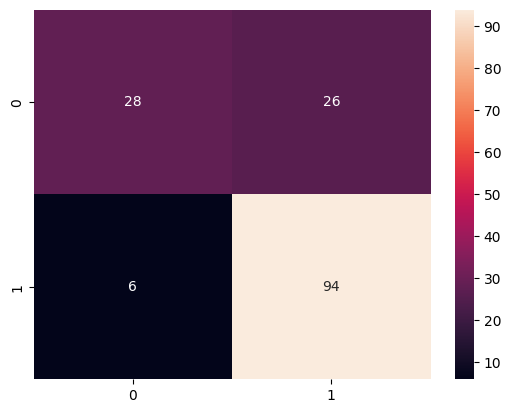

In [30]:
cm = confusion_matrix(y_test,y_pred)
cm
sns.heatmap(cm,annot=True)